In [1]:
# Data manipulation
# ==============================================================================
import pandas as pd
import numpy as np
from skforecast.datasets import fetch_dataset


# Plots
# ==============================================================================
import matplotlib.pyplot as plt
#from skforecast.plot import set_dark_theme

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import (
    TimeSeriesFold,
    backtesting_forecaster_multiseries,
    grid_search_forecaster_multiseries
)

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

c:\Users\maria.diazalba\OneDrive - Cordis US Corp\0 MARIA\SKU Demand\venv_psr\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_excel("./results/df_complete.xlsx")
data = data.rename(columns={"SKU": "series_id"})
data = data.rename(columns={"week": "timestamp"})
data['timestamp'] = pd.to_datetime(data['timestamp'])
if 'timestamp' in data.columns:
    data.insert(0, 'timestamp', data.pop('timestamp'))
data

,timestamp,series_id,Brand,MFG Class,Resource ID,ADD
0,2024-07-03,12000210,ARC ROYAL,O01,EM_O01_NL,9.85
1,2024-07-03,12000235,ARC ROYAL,O01,EM_O01_NL,0.76
2,2024-07-03,12000236,ARC ROYAL,O01,EM_O01_NL,9.09
3,2024-07-03,12000237,ARC ROYAL,O02,EM_O02_NL,1.52
4,2024-07-03,12000249,ARC ROYAL,O02,EM_O02_NL,2.65
...,...,...,...,...,...,...
244468,2025-07-30,ZE-6-120,IKAZUCHI ZERO,O84,EM_O84_NL_CN,1.31
244469,2025-07-30,ZE-6-200,IKAZUCHI ZERO,O84,EM_O84_NL_CN,0.08
244470,2025-07-30,ZE-6-250,IKAZUCHI ZERO,O84,EM_O84_NL_CN,0.00
244471,2025-07-30,ZE-8-100P,IKAZUCHI ZERO,O84,EM_O84_NL_CN,9.87


### Check Brand, Resource ID and series_id: search for duplicates and Nan

In [3]:
base = data[['Brand','Resource ID','series_id']]
n0 = len(base)
n_non_null = len(base.dropna())
n_unique_triples = len(base.dropna().drop_duplicates())

print("Filas totales:", n0)
print("Sin NA:", n_non_null)
print("Tripletas únicas (Brand, Resource ID, series_id):", n_unique_triples)
print("Eliminadas por NA:", n0 - n_non_null)
print("Duplicados exactos eliminados:", n_non_null - n_unique_triples)

Filas totales: 244473
Sin NA: 243846
Tripletas únicas (Brand, Resource ID, series_id): 4278
Eliminadas por NA: 627
Duplicados exactos eliminados: 239568


Hay 11 SKUS que no tienen ResourceID (esta en blanco) lo que da lugar a 627 NaN en el df completo.

Se completan con la info aportada a posteriori

In [4]:
skus_nan = (data.loc[data['Resource ID'].isna(), 'series_id']
              .dropna()
              .unique())

print(f"SKUs a eliminar (Resource ID NaN): {len(skus_nan)}")

SKUs a eliminar (Resource ID NaN): 11


In [5]:
data.loc[data['Resource ID'].isna(), 'Resource ID'] = 'EM_O92'
data.loc[data['MFG Class'].isna(), 'MFG Class'] = 'O92'

print("Filas restantes:", len(data))
print("Resource ID NaN restantes:", data['Resource ID'].isna().sum())

Filas restantes: 244473
Resource ID NaN restantes: 0


In [6]:
last_date  = data['timestamp'].max()
end_train  = (last_date - pd.Timedelta(weeks=4))
start_test = end_train + pd.Timedelta(weeks=1)

print("Global split:")
print("  end_train :", end_train.date())
print("  start_test:", start_test.date(), " -> last_date:", last_date.date())

df_train = data.loc[data['timestamp'] <= end_train].copy()
df_test  = data.loc[data['timestamp'] >= start_test].copy()

print("Shapes -> series_train:", df_train.shape, " | series_test:", df_test.shape)
df_test

Global split:
  end_train : 2025-07-02
  start_test: 2025-07-09  -> last_date: 2025-07-30
Shapes -> series_train: (227317, 6)  | series_test: (17156, 6)


,timestamp,series_id,Brand,MFG Class,Resource ID,ADD
227317,2025-07-09,12000210,ARC ROYAL,O01,EM_O01_NL,6.82
227318,2025-07-09,12000235,ARC ROYAL,O01,EM_O01_NL,0.00
227319,2025-07-09,12000236,ARC ROYAL,O01,EM_O01_NL,1.52
227320,2025-07-09,12000237,ARC ROYAL,O02,EM_O02_NL,0.00
227321,2025-07-09,12000249,ARC ROYAL,O02,EM_O02_NL,0.00
...,...,...,...,...,...,...
244468,2025-07-30,ZE-6-120,IKAZUCHI ZERO,O84,EM_O84_NL_CN,1.31
244469,2025-07-30,ZE-6-200,IKAZUCHI ZERO,O84,EM_O84_NL_CN,0.08
244470,2025-07-30,ZE-6-250,IKAZUCHI ZERO,O84,EM_O84_NL_CN,0.00
244471,2025-07-30,ZE-8-100P,IKAZUCHI ZERO,O84,EM_O84_NL_CN,9.87


### % SPLIT

- n_skus: numero de skus que corresponden a una agrupacion unica de Brand - Resource ID
- ADD_rec: Suma de ADD de los skus de la anterior agrupacion, es decir, de los skus de un mismo recurso dentro de una brand.
- ADD_brand: Suma de ADD_sum por cada Brand
- split_pct: Porcentaje que representa ADD_sum sobre el total de ADD_brand, es decir, el procentaje de ADD asignado a cada recurso dentro de una misma Brand.

In [7]:
df = df_test.copy()

In [9]:
''' Codigo para comprobar antes de insertar n_skus'''
pairs = (df[['Brand','Resource ID','series_id']]
         .dropna()
         .drop_duplicates())
#with pd.option_context(
#    'display.max_rows', None,
#    'display.max_columns', None,
#    'display.width', None,
#    'display.max_colwidth', None
#):
#    display(pairs)
display(pairs)

,Brand,Resource ID,series_id
227317,ARC ROYAL,EM_O01_NL,12000210
227318,ARC ROYAL,EM_O01_NL,12000235
227319,ARC ROYAL,EM_O01_NL,12000236
227320,ARC ROYAL,EM_O02_NL,12000237
227321,ARC ROYAL,EM_O02_NL,12000249
...,...,...,...
231601,IKAZUCHI ZERO,EM_O84_NL_CN,ZE-6-120
231602,IKAZUCHI ZERO,EM_O84_NL_CN,ZE-6-200
231603,IKAZUCHI ZERO,EM_O84_NL_CN,ZE-6-250
231604,IKAZUCHI ZERO,EM_O84_NL_CN,ZE-8-100P


In [10]:
df['n_skus'] = df.groupby(['Brand','Resource ID'])['series_id'].transform('nunique')
df

,timestamp,series_id,Brand,MFG Class,Resource ID,ADD,n_skus
227317,2025-07-09,12000210,ARC ROYAL,O01,EM_O01_NL,6.82,5
227318,2025-07-09,12000235,ARC ROYAL,O01,EM_O01_NL,0.00,5
227319,2025-07-09,12000236,ARC ROYAL,O01,EM_O01_NL,1.52,5
227320,2025-07-09,12000237,ARC ROYAL,O02,EM_O02_NL,0.00,20
227321,2025-07-09,12000249,ARC ROYAL,O02,EM_O02_NL,0.00,20
...,...,...,...,...,...,...,...
244468,2025-07-30,ZE-6-120,IKAZUCHI ZERO,O84,EM_O84_NL_CN,1.31,46
244469,2025-07-30,ZE-6-200,IKAZUCHI ZERO,O84,EM_O84_NL_CN,0.08,46
244470,2025-07-30,ZE-6-250,IKAZUCHI ZERO,O84,EM_O84_NL_CN,0.00,46
244471,2025-07-30,ZE-8-100P,IKAZUCHI ZERO,O84,EM_O84_NL_CN,9.87,46


In [11]:

df['ADD_rec'] = df.groupby(['timestamp','Brand','Resource ID'])['ADD'].transform('sum')
df

,timestamp,series_id,Brand,MFG Class,Resource ID,ADD,n_skus,ADD_rec
227317,2025-07-09,12000210,ARC ROYAL,O01,EM_O01_NL,6.82,5,14.02
227318,2025-07-09,12000235,ARC ROYAL,O01,EM_O01_NL,0.00,5,14.02
227319,2025-07-09,12000236,ARC ROYAL,O01,EM_O01_NL,1.52,5,14.02
227320,2025-07-09,12000237,ARC ROYAL,O02,EM_O02_NL,0.00,20,82.58
227321,2025-07-09,12000249,ARC ROYAL,O02,EM_O02_NL,0.00,20,82.58
...,...,...,...,...,...,...,...,...
244468,2025-07-30,ZE-6-120,IKAZUCHI ZERO,O84,EM_O84_NL_CN,1.31,46,248.68
244469,2025-07-30,ZE-6-200,IKAZUCHI ZERO,O84,EM_O84_NL_CN,0.08,46,248.68
244470,2025-07-30,ZE-6-250,IKAZUCHI ZERO,O84,EM_O84_NL_CN,0.00,46,248.68
244471,2025-07-30,ZE-8-100P,IKAZUCHI ZERO,O84,EM_O84_NL_CN,9.87,46,248.68


In [12]:
# 1) Vista a nivel recurso (quitar duplicados por snapshot-brand-resource)
res_level = (df[['timestamp','Brand','Resource ID','ADD_rec']]
             .dropna(subset=['ADD_rec'])
             .drop_duplicates(subset=['timestamp','Brand','Resource ID']))

# 2) Suma por Brand y snapshot
brand_totals = (res_level.groupby(['timestamp','Brand'], as_index=False)['ADD_rec']
                        .sum()
                        .rename(columns={'ADD_rec':'ADD_brand'}))

# 3) Añadir al df original
df = df.merge(brand_totals, on=['timestamp','Brand'], how='left')
df

,timestamp,series_id,Brand,MFG Class,Resource ID,ADD,n_skus,ADD_rec,ADD_brand
0,2025-07-09,12000210,ARC ROYAL,O01,EM_O01_NL,6.82,5,14.02,138.54
1,2025-07-09,12000235,ARC ROYAL,O01,EM_O01_NL,0.00,5,14.02,138.54
2,2025-07-09,12000236,ARC ROYAL,O01,EM_O01_NL,1.52,5,14.02,138.54
3,2025-07-09,12000237,ARC ROYAL,O02,EM_O02_NL,0.00,20,82.58,138.54
4,2025-07-09,12000249,ARC ROYAL,O02,EM_O02_NL,0.00,20,82.58,138.54
...,...,...,...,...,...,...,...,...,...
17151,2025-07-30,ZE-6-120,IKAZUCHI ZERO,O84,EM_O84_NL_CN,1.31,46,248.68,248.68
17152,2025-07-30,ZE-6-200,IKAZUCHI ZERO,O84,EM_O84_NL_CN,0.08,46,248.68,248.68
17153,2025-07-30,ZE-6-250,IKAZUCHI ZERO,O84,EM_O84_NL_CN,0.00,46,248.68,248.68
17154,2025-07-30,ZE-8-100P,IKAZUCHI ZERO,O84,EM_O84_NL_CN,9.87,46,248.68,248.68


In [13]:
# Comprobacion de los dos escenarios problematicos

by = ['timestamp', 'Brand']

# --- Stats a nivel (timestamp, Brand) ---
brand_stats = (df
    .groupby(by)
    .agg(
        n_resources=('Resource ID', 'nunique'),
        n_nonzero=('ADD_rec', lambda s: (s.fillna(0) > 0).sum()),
        all_nan=('ADD_rec', lambda s: s.isna().all())
    )
    .reset_index()
)

# Añadir las stats al nivel fila
df = df.merge(brand_stats, on=by, how='left')

# --- Escenarios ---
mask_add0 = df['ADD_brand'].fillna(0).eq(0)

mask_purple = (
    mask_add0 &
    df['n_resources'].eq(1) &       # solo 1 recurso
    ~df['all_nan']                  # y no es "todo NaN"
)

mask_green = (
    mask_add0 &
    df['n_resources'].gt(1) &       # varios recursos
    df['n_nonzero'].eq(0) &         # ninguno > 0
    ~df['all_nan']
)

# Filas correspondientes a cada escenario (para inspección)
df_purple = df.loc[mask_purple, ['timestamp','Brand','Resource ID','ADD_rec','ADD_brand','n_resources']]
df_green  = df.loc[mask_green,  ['timestamp','Brand','Resource ID','ADD_rec','ADD_brand','n_resources']]


In [14]:
m_pos = df['ADD_brand'].gt(0)

df['split_pct'] = np.nan
# caso normal: ADD_brand > 0
df.loc[m_pos, 'split_pct'] = 100 * df.loc[m_pos, 'ADD_rec'] / df.loc[m_pos, 'ADD_brand']
# caso green: ADD_brand == 0 y >1 recurso (reparto igual)
df.loc[~m_pos, 'split_pct'] = 100.0 / df['n_resources']
df

,timestamp,series_id,Brand,MFG Class,Resource ID,ADD,n_skus,ADD_rec,ADD_brand,n_resources,n_nonzero,all_nan,split_pct
0,2025-07-09,12000210,ARC ROYAL,O01,EM_O01_NL,6.82,5,14.02,138.54,3,26,False,10.119821
1,2025-07-09,12000235,ARC ROYAL,O01,EM_O01_NL,0.00,5,14.02,138.54,3,26,False,10.119821
2,2025-07-09,12000236,ARC ROYAL,O01,EM_O01_NL,1.52,5,14.02,138.54,3,26,False,10.119821
3,2025-07-09,12000237,ARC ROYAL,O02,EM_O02_NL,0.00,20,82.58,138.54,3,26,False,59.607334
4,2025-07-09,12000249,ARC ROYAL,O02,EM_O02_NL,0.00,20,82.58,138.54,3,26,False,59.607334
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17151,2025-07-30,ZE-6-120,IKAZUCHI ZERO,O84,EM_O84_NL_CN,1.31,46,248.68,248.68,1,46,False,100.000000
17152,2025-07-30,ZE-6-200,IKAZUCHI ZERO,O84,EM_O84_NL_CN,0.08,46,248.68,248.68,1,46,False,100.000000
17153,2025-07-30,ZE-6-250,IKAZUCHI ZERO,O84,EM_O84_NL_CN,0.00,46,248.68,248.68,1,46,False,100.000000
17154,2025-07-30,ZE-8-100P,IKAZUCHI ZERO,O84,EM_O84_NL_CN,9.87,46,248.68,248.68,1,46,False,100.000000


In [15]:
import os
output_path = os.path.join('./results', 'split_test.xlsx')
df.to_excel(output_path, index=False)

Revision de ADD totales por marcas y recursos

In [16]:
mask = (df['Brand']=='FRONTRUNNER') & (df['timestamp']==pd.Timestamp('2025-07-30'))
print(df.loc[mask, ['Resource ID','ADD_rec', 'split_pct']].drop_duplicates())  
print(df.loc[mask, 'ADD_brand'].drop_duplicates())                

      Resource ID  ADD_rec  split_pct
15863         X00      0.0      100.0
15863    0.0
Name: ADD_brand, dtype: float64


In [17]:
d = pd.Timestamp('2025-07-09')
subset = df.loc[(df['Brand'] == 'ADROIT') & (df['timestamp'] == d)]
subset

,timestamp,series_id,Brand,MFG Class,Resource ID,ADD,n_skus,ADD_rec,ADD_brand,n_resources,n_nonzero,all_nan,split_pct
2127,2025-07-09,55800000,ADROIT,E00,E00A,0.06,36,2.73,602.32,2,153,False,0.453247
2128,2025-07-09,55800200,ADROIT,E00,E00A,0.00,36,2.73,602.32,2,153,False,0.453247
2129,2025-07-09,55800400,ADROIT,E00,E00A,0.00,36,2.73,602.32,2,153,False,0.453247
2130,2025-07-09,55800600,ADROIT,E00,E00A,0.05,36,2.73,602.32,2,153,False,0.453247
2131,2025-07-09,55800800,ADROIT,E00,E00A,0.00,36,2.73,602.32,2,153,False,0.453247
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,2025-07-09,67272900,ADROIT,E00,E00B,0.00,117,599.59,602.32,2,153,False,99.546753
2516,2025-07-09,67273000,ADROIT,E00,E00B,0.00,117,599.59,602.32,2,153,False,99.546753
2517,2025-07-09,67273200,ADROIT,E00,E00B,0.00,117,599.59,602.32,2,153,False,99.546753
2518,2025-07-09,67273400,ADROIT,E00,E00B,0.30,117,599.59,602.32,2,153,False,99.546753


In [18]:
chk = (df[['timestamp','Brand','Resource ID','split_pct']]
       .drop_duplicates(subset=['timestamp','Brand','Resource ID'])
       .groupby(['timestamp','Brand'])['split_pct'].sum()
       .round(2))

with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', None,
    'display.max_colwidth', None
):
    display(chk)

timestamp   Brand                       
2025-07-09  ADROIT                          100.0
            ANGIOGUARD                      100.0
            AQUATRACK                       100.0
            ARC ROYAL                       100.0
            ATW WIRE                        100.0
            ATW WIRE MARKER                 100.0
            AVANTI PLUS                     100.0
            AVIATOR PLUS                    100.0
            BIOPSY FORCEPS STD              100.0
            BIPAL                           100.0
            BLUE on AVIATOR                 100.0
            BLUE on SLALOM                  100.0
            BRITE TIP                       100.0
            BRITE TIP (MODIFIED)            100.0
            BRITE TIP RADIANZ               100.0
            BriteCross Support Catheters    100.0
            CATH EXT                        100.0
            CORPACK                         100.0
            CORPACK (MODIFIED)              100.0
         

In [19]:
def reporte_brand_snapshot(df: pd.DataFrame, brand: str, snapshot_yyyy_mm_dd: str, add_col=None):
    """
    Genera un reporte para (Brand, Snapshot) SIN recalcular split_pct ni re-sumar recursos.
    Requiere columnas: ['timestamp','Brand','series_id','Resource ID','ADD','ADD_rec','ADD_brand','split_pct'].

    Devuelve (recursos_df, skus_df).
    """
    if add_col not in df.columns: 
        raise KeyError(f"Column '{add_col}' no existe en el DataFrame.")
    
    mask = (
        df['Brand'].eq(brand)
        & df['timestamp'].astype(str).str[:10].eq(snapshot_yyyy_mm_dd)
    )
    dfb = df.loc[mask].copy()  # copia temporal solo para columnas derivadas

    total_add = float(dfb['ADD_brand'].iloc[0])
    n_recursos = dfb['Resource ID'].nunique()
    n_skus = dfb['series_id'].nunique()

    print("\n=== SUMMARY ===")
    print(f"Brand: {brand}")
    print(f"Snapshot: {snapshot_yyyy_mm_dd}")
    print(f"ADD total of Brand: {round(total_add, 2)}")
    print(f"# Resources: {n_recursos}  |  # SKUs: {n_skus}")

    recursos = (
        dfb[['Resource ID', 'ADD_rec', 'split_pct']]
        .drop_duplicates(subset=['Resource ID'])
        .rename(columns={'ADD_rec': 'ADD_resource', 'split_pct': '%_brand'})
        .sort_values('ADD_resource', ascending=False)
        .reset_index(drop=True)
    )

    print("\n=== RESOURCES (sorted by ADD) ===")
    print(recursos.assign(
        ADD_resource=lambda d: d['ADD_resource'].round(2),
        **{'%_brand': recursos['%_brand'].round(2)}
    ).to_string(index=False))

    # % del SKU sobre la brand
    n_skus_brand = dfb['series_id'].nunique()
    dfb['%_brand'] = np.where(
        total_add > 0,
        100.0 * dfb[add_col] / total_add,
        100.0 / n_skus_brand          # si total_add == 0 → repartir a partes iguales
    )

    # % del SKU dentro de su recurso
    n_skus_en_recurso = dfb.groupby('Resource ID')['series_id'].transform('nunique')
    dfb['%_in_resource'] = np.where(
        dfb['ADD_rec'] > 0,
        100.0 * dfb[add_col] / dfb['ADD_rec'],
        100.0 / n_skus_en_recurso     # si ADD_rec == 0 → repartir a partes iguales
    )

    skus = ( dfb[['series_id', 'Resource ID', add_col, '%_brand', '%_in_resource']] 
            .sort_values(add_col, ascending=False) 
            .reset_index(drop=True) 
    )

    print("\n=== SKUs (sorted by ADD) ===")
    print(
        skus.assign(
            **{
                add_col: skus[add_col].round(2),
                '%_brand': skus['%_brand'].round(2),
                '%_in_resource': skus['%_in_resource'].round(2),
            }
        ).to_string(index=False)
    )

    return recursos, skus

### SIMULATION: Test Set vs Predictions

Aplicaremos los mismos calculos al df predictions que contiene los valores de ADD predecidos para el conjunto de set. Obtendremos % split calculado a partir de las predicciones

Usaremos el df_test para comparar los split % reales de los creados a partir de predictions

In [20]:
predictions = pd.read_excel("./results/predictions.xlsx")
predictions = predictions.rename(columns={"level": "series_id"})
predictions = predictions.rename(columns={"pred_original": "ADD"})
predictions['timestamp'] = pd.to_datetime(predictions['timestamp'])
predictions

,timestamp,series_id,z_pred,z_ADD,z_abs_error,sigma,mu,ADD,ADD_original,abs_error
0,2025-07-09,12000210,0.126833,-0.042459,0.169293,2.484075,6.925472,7.240535,6.82,0.420535
1,2025-07-09,12000235,-1.024229,-1.004276,0.019952,0.855023,0.858679,-0.017060,0.00,0.017060
2,2025-07-09,12000236,-0.465954,-0.427046,0.038908,2.953596,2.781321,1.405082,1.52,0.114918
3,2025-07-09,12000237,-1.101118,-1.101928,0.000811,0.851166,0.937925,0.000690,0.00,0.000690
4,2025-07-09,12000249,-2.043379,-2.133732,0.090353,2.328633,4.968679,0.210400,0.00,0.210400
...,...,...,...,...,...,...,...,...,...,...
17151,2025-07-30,ZE-6-120,0.943446,-0.693281,1.636727,0.399794,1.587170,1.964354,1.31,0.654354
17152,2025-07-30,ZE-6-200,-0.979959,-2.085200,1.105241,0.062344,0.210000,0.148905,0.08,0.068905
17153,2025-07-30,ZE-6-250,-0.993304,-1.914864,0.921560,0.039315,0.075283,0.036231,0.00,0.036231
17154,2025-07-30,ZE-8-100P,0.776396,1.927237,1.150841,0.736023,8.451509,9.022955,9.87,0.847045


In [21]:
keys = ['timestamp', 'series_id']

pred_map = (predictions.drop_duplicates(subset=keys, keep='last')
                        .set_index(keys)['ADD'])
pred_map = pred_map.mask(pred_map < 0, 0)

df_test_pred = df_test.copy().set_index(keys)
df_test_pred['ADD'] = pred_map.reindex(df_test_pred.index).values
df_test_pred = df_test_pred.reset_index()
df_test_pred = df_test_pred.rename(columns = {'ADD': 'ADD_pred'})
df_test_pred

,timestamp,series_id,Brand,MFG Class,Resource ID,ADD_pred
0,2025-07-09,12000210,ARC ROYAL,O01,EM_O01_NL,7.240535
1,2025-07-09,12000235,ARC ROYAL,O01,EM_O01_NL,0.000000
2,2025-07-09,12000236,ARC ROYAL,O01,EM_O01_NL,1.405082
3,2025-07-09,12000237,ARC ROYAL,O02,EM_O02_NL,0.000690
4,2025-07-09,12000249,ARC ROYAL,O02,EM_O02_NL,0.210400
...,...,...,...,...,...,...
17151,2025-07-30,ZE-6-120,IKAZUCHI ZERO,O84,EM_O84_NL_CN,1.964354
17152,2025-07-30,ZE-6-200,IKAZUCHI ZERO,O84,EM_O84_NL_CN,0.148905
17153,2025-07-30,ZE-6-250,IKAZUCHI ZERO,O84,EM_O84_NL_CN,0.036231
17154,2025-07-30,ZE-8-100P,IKAZUCHI ZERO,O84,EM_O84_NL_CN,9.022955


In [22]:
df_test_pred['ADD_rec'] = df_test_pred.groupby(['timestamp','Brand','Resource ID'])['ADD_pred'].transform('sum')

res_level = (df_test_pred[['timestamp','Brand','Resource ID','ADD_rec']]
             .dropna(subset=['ADD_rec'])
             .drop_duplicates(subset=['timestamp','Brand','Resource ID']))

brand_totals = (res_level.groupby(['timestamp','Brand'], as_index=False)['ADD_rec']
                        .sum()
                        .rename(columns={'ADD_rec':'ADD_brand'}))

df_test_pred = df_test_pred.merge(brand_totals, on=['timestamp','Brand'], how='left')

m_pos_pred = df_test_pred['ADD_brand'].gt(0)

n_res = df_test_pred.groupby(['timestamp', 'Brand'])['Resource ID'].transform('nunique')

df_test_pred['split_pct'] = np.nan
df_test_pred.loc[m_pos_pred, 'split_pct'] = 100 * df_test_pred.loc[m_pos_pred, 'ADD_rec'] / df_test_pred.loc[m_pos_pred, 'ADD_brand']
df_test_pred.loc[~m_pos_pred, 'split_pct'] = 100.0 / n_res
df_test_pred

,timestamp,series_id,Brand,MFG Class,Resource ID,ADD_pred,ADD_rec,ADD_brand,split_pct
0,2025-07-09,12000210,ARC ROYAL,O01,EM_O01_NL,7.240535,14.255832,139.657001,10.207746
1,2025-07-09,12000235,ARC ROYAL,O01,EM_O01_NL,0.000000,14.255832,139.657001,10.207746
2,2025-07-09,12000236,ARC ROYAL,O01,EM_O01_NL,1.405082,14.255832,139.657001,10.207746
3,2025-07-09,12000237,ARC ROYAL,O02,EM_O02_NL,0.000690,82.967459,139.657001,59.408020
4,2025-07-09,12000249,ARC ROYAL,O02,EM_O02_NL,0.210400,82.967459,139.657001,59.408020
...,...,...,...,...,...,...,...,...,...
17151,2025-07-30,ZE-6-120,IKAZUCHI ZERO,O84,EM_O84_NL_CN,1.964354,283.169612,283.169612,100.000000
17152,2025-07-30,ZE-6-200,IKAZUCHI ZERO,O84,EM_O84_NL_CN,0.148905,283.169612,283.169612,100.000000
17153,2025-07-30,ZE-6-250,IKAZUCHI ZERO,O84,EM_O84_NL_CN,0.036231,283.169612,283.169612,100.000000
17154,2025-07-30,ZE-8-100P,IKAZUCHI ZERO,O84,EM_O84_NL_CN,9.022955,283.169612,283.169612,100.000000


In [ ]:
output_path = os.path.join('./results', 'split_pred.xlsx')
df_test_pred.to_excel(output_path, index=False)

## REPORT TEST

In [25]:
if __name__ == "__main__":
    brand = input("Brand: ").strip()
    snapshot = input("Snapshot (AAAA-MM-DD): ").strip()
    reporte_brand_snapshot(df, brand, snapshot, add_col="ADD")


=== SUMMARY ===
Brand: ARC ROYAL
Snapshot: 2025-07-30
ADD total of Brand: 117.13
# Resources: 3  |  # SKUs: 26

=== RESOURCES (sorted by ADD) ===
Resource ID  ADD_resource  %_brand
  EM_O02_NL         85.62    73.10
     EM_O02         22.42    19.14
  EM_O01_NL          9.09     7.76

=== SKUs (sorted by ADD) ===
series_id Resource ID   ADD  %_brand  %_in_resource
 12001740   EM_O02_NL 34.85    29.75          40.70
 12001855   EM_O02_NL 23.48    20.05          27.42
 12003704      EM_O02 22.42    19.14         100.00
 12001736   EM_O02_NL 11.75    10.03          13.72
 12000304   EM_O02_NL 10.61     9.06          12.39
 12000210   EM_O01_NL  5.68     4.85          62.49
 12000836   EM_O01_NL  1.89     1.61          20.79
 12001734   EM_O02_NL  1.89     1.61           2.21
 12000236   EM_O01_NL  1.14     0.97          12.54
 12001733   EM_O02_NL  1.14     0.97           1.33
 12001737   EM_O02_NL  1.14     0.97           1.33
 12001738   EM_O02_NL  0.76     0.65           0.89
 120017

## REPORT PREDICTIONS

In [75]:
if __name__ == "__main__":
    brand = input("Brand: ").strip()
    snapshot = input("Snapshot (AAAA-MM-DD): ").strip()
    reporte_brand_snapshot(df_test_pred, brand, snapshot, add_col="ADD_pred")


=== SUMMARY ===
Brand: ARC ROYAL
Snapshot: 2025-07-09
ADD total of Brand: 139.66
# Resources: 3  |  # SKUs: 26

=== RESOURCES (sorted by ADD) ===
Resource ID  ADD_resource  %_brand
  EM_O02_NL         82.97    59.41
     EM_O02         42.43    30.38
  EM_O01_NL         14.26    10.21

=== SKUs (sorted by ADD) ===
series_id Resource ID  ADD_pred  %_brand  %_in_resource
 12003704      EM_O02     42.43    30.38         100.00
 12001740   EM_O02_NL     31.58    22.61          38.07
 12001855   EM_O02_NL     24.12    17.27          29.07
 12001736   EM_O02_NL     14.41    10.32          17.37
 12000210   EM_O01_NL      7.24     5.18          50.79
 12000304   EM_O02_NL      4.96     3.55           5.98
 12000836   EM_O01_NL      4.76     3.41          33.39
 12001734   EM_O02_NL      2.59     1.85           3.12
 12001737   EM_O02_NL      1.47     1.05           1.77
 12000236   EM_O01_NL      1.41     1.01           9.86
 12001915   EM_O02_NL      1.39     0.99           1.67
 12001776  

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def _split_por_recurso(
    df: pd.DataFrame,
    brand: str | None,
    snapshot: str | None,
    resource_col: str = "Resource ID",
    split_col: str = "split_pct",
) -> pd.Series:
    """Devuelve el % de brand por recurso (0–100) leyendo directamente `split_pct`."""
    req = {"Brand", "timestamp", resource_col, split_col}
    missing = req.difference(df.columns)
    if missing:
        raise KeyError(f"Faltan columnas en df: {sorted(missing)}")

    d = df
    if brand is not None:
        d = d[d["Brand"].eq(brand)]
    if snapshot is not None:
        d = d[d["timestamp"].astype(str).str[:10].eq(snapshot)]

    if d.empty:
        return pd.Series(dtype=float)

    # `split_pct` es constante por recurso → tomamos el primero
    s = d.groupby(resource_col, dropna=False)[split_col].first()
    return s.sort_values(ascending=False)


def plot_resource_share_comparison(
    df_test: pd.DataFrame,
    df_pred: pd.DataFrame,
    brand: str | None = None,
    snapshot: str | None = None,
    resource_col: str = "Resource ID",
    split_col_test: str = "split_pct",
    split_col_pred: str = "split_pct",
    show_value_labels: bool = True,
    label_decimals: int = 1,
    figsize: tuple[float, float] = (8, 5),
    title_prefix: str = "% de Brand por Resource"
) -> pd.DataFrame:
    """
    Compara **directamente** los `split_pct` de test vs pred por recurso y grafica.
    Devuelve un DataFrame con `%_brand_test`, `%_brand_pred` y `delta_pp`.
    """
    s_test = _split_por_recurso(df_test, brand, snapshot, resource_col, split_col_test)
    s_pred = _split_por_recurso(df_pred, brand, snapshot, resource_col, split_col_pred)

    # recursos presentes en cualquiera de los dos
    resources = list(dict.fromkeys(list(s_test.index) + list(s_pred.index)))  # conserva orden de s_test
    comp = pd.DataFrame({
        "%_brand_test": s_test.reindex(resources).fillna(0.0),
        "%_brand_pred": s_pred.reindex(resources).fillna(0.0),
    })
    comp["delta_pp"] = comp["%_brand_pred"] - comp["%_brand_test"]

    # --- plot ---
    x = np.arange(len(resources))
    width = 0.35
    fig, ax = plt.subplots(figsize=figsize)
    bars_test = ax.bar(x - width/2, comp["%_brand_test"].to_numpy(), width, label="Test")
    bars_pred = ax.bar(x + width/2, comp["%_brand_pred"].to_numpy(), width, label="Pred")

    if show_value_labels:
        fmt = f"%.{label_decimals}f%%"
        ax.bar_label(bars_test, labels=[fmt % v for v in comp["%_brand_test"].to_numpy()], padding=2)
        ax.bar_label(bars_pred, labels=[fmt % v for v in comp["%_brand_pred"].to_numpy()], padding=2)

    ax.set_xticks(x)
    ax.set_xticklabels(resources, rotation=0)
    subtitle = f" — {brand}" if brand else ""
    datebit = f" — {snapshot}" if snapshot else ""
    ax.set_title(f"{title_prefix}{subtitle}{datebit}")
    ax.set_ylabel("% del Brand")
    ax.legend()
    fig.tight_layout()
    plt.show()

    return comp


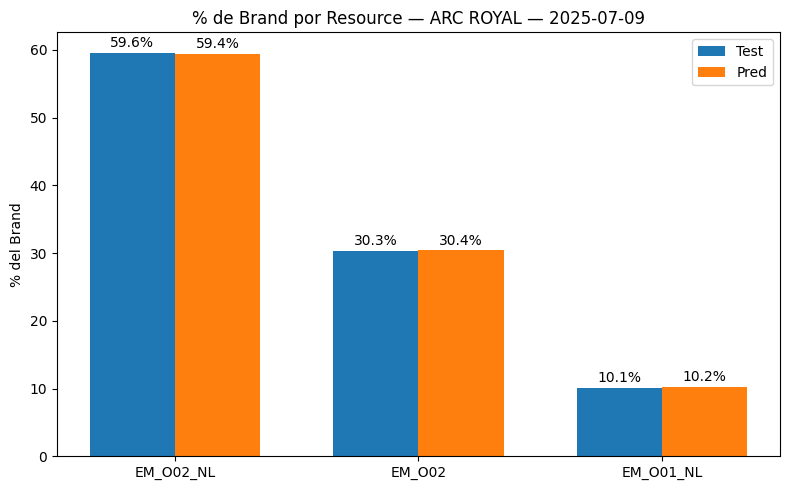

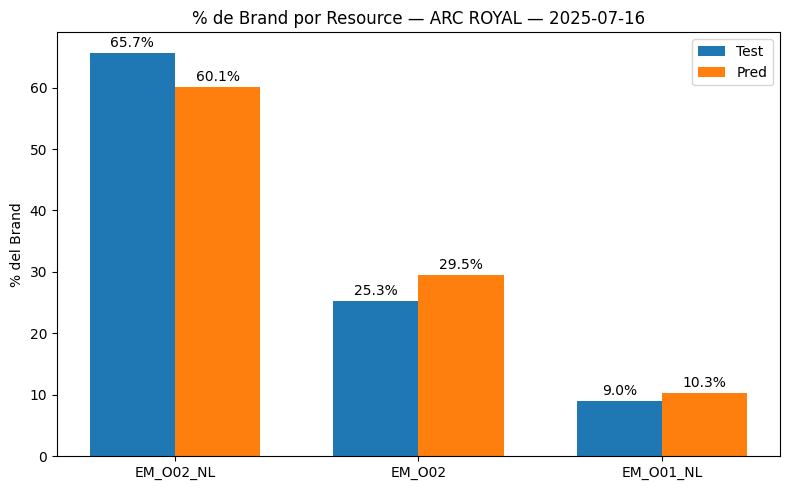

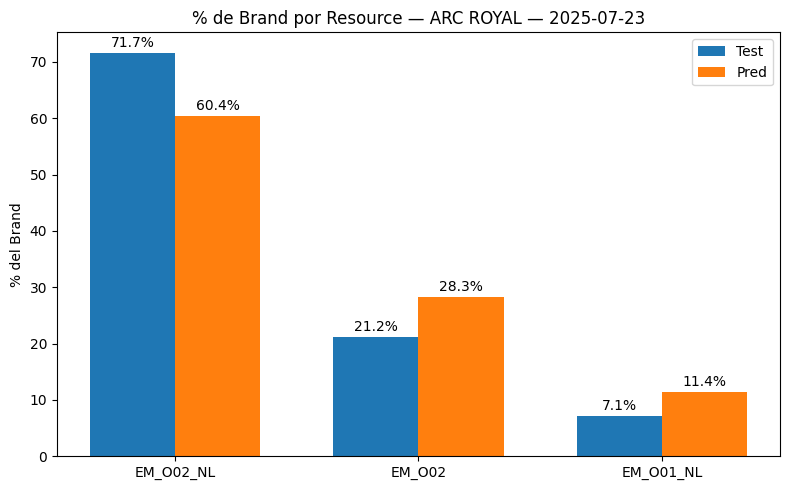

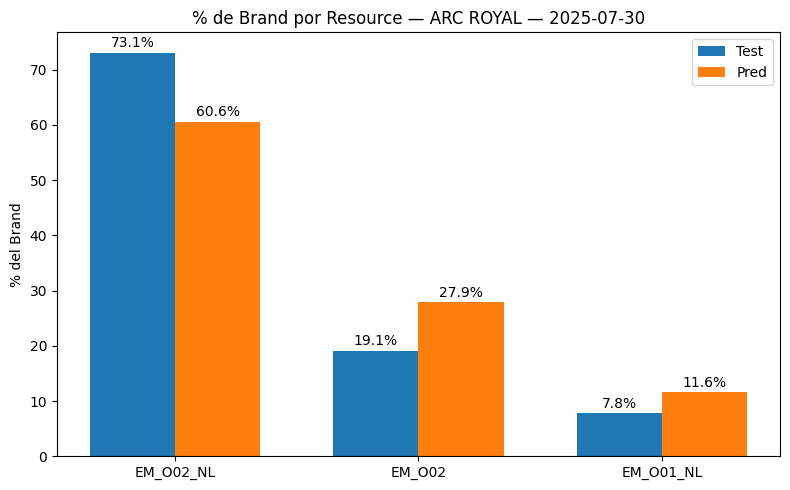

In [99]:
snapshots = ["2025-07-09", '2025-07-16', '2025-07-23', '2025-07-30' ]
for snapshot in snapshots:
    out = plot_resource_share_comparison(
        df,
        df_test_pred,
        brand="ARC ROYAL",          
        snapshot=snapshot     
    )

In [100]:
d = pd.Timestamp('2025-07-09')
subset = df.loc[(df['Brand'] == 'ARC ROYAL') & (df['timestamp'] == d)]
subset

,timestamp,series_id,Brand,MFG Class,Resource ID,ADD,n_skus,ADD_rec,ADD_brand,n_resources,n_nonzero,all_nan,split_pct
0,2025-07-09,12000210,ARC ROYAL,O01,EM_O01_NL,6.82,5,14.02,138.54,3,26,False,10.119821
1,2025-07-09,12000235,ARC ROYAL,O01,EM_O01_NL,0.00,5,14.02,138.54,3,26,False,10.119821
2,2025-07-09,12000236,ARC ROYAL,O01,EM_O01_NL,1.52,5,14.02,138.54,3,26,False,10.119821
3,2025-07-09,12000237,ARC ROYAL,O02,EM_O02_NL,0.00,20,82.58,138.54,3,26,False,59.607334
4,2025-07-09,12000249,ARC ROYAL,O02,EM_O02_NL,0.00,20,82.58,138.54,3,26,False,59.607334
5,2025-07-09,12000304,ARC ROYAL,O02,EM_O02_NL,5.30,20,82.58,138.54,3,26,False,59.607334
6,2025-07-09,12000608,ARC ROYAL,O02,EM_O02_NL,0.00,20,82.58,138.54,3,26,False,59.607334
7,2025-07-09,12000813,ARC ROYAL,O02,EM_O02_NL,0.00,20,82.58,138.54,3,26,False,59.607334
8,2025-07-09,12000836,ARC ROYAL,O01,EM_O01_NL,4.92,5,14.02,138.54,3,26,False,10.119821
10,2025-07-09,12001733,ARC ROYAL,O02,EM_O02_NL,1.14,20,82.58,138.54,3,26,False,59.607334


In [91]:
filtro = df_test_pred[df_test_pred['Brand'] == 'KOBI CAROTID']
filtro

,timestamp,series_id,Brand,MFG Class,Resource ID,ADD_pred,ADD_rec,ADD_brand,split_pct
3029,2025-07-09,K0520RXTC,KOBI CAROTID,T02,T02B,0.00000,0.000000,0.000000,100.0
3030,2025-07-09,K0520RXTCE,KOBI CAROTID,T02,T02B,0.00000,0.000000,0.000000,100.0
3031,2025-07-09,K0530RXTC,KOBI CAROTID,T02,T02B,0.00000,0.000000,0.000000,100.0
3032,2025-07-09,K0530RXTCE,KOBI CAROTID,T02,T02B,0.00000,0.000000,0.000000,100.0
3033,2025-07-09,K0540RXTC,KOBI CAROTID,T02,T02B,0.00000,0.000000,0.000000,100.0
...,...,...,...,...,...,...,...,...,...
15927,2025-07-30,K1020RXTCE,KOBI CAROTID,T02,T02B,0.04011,1.443953,1.443953,100.0
15928,2025-07-30,K1030RXTC,KOBI CAROTID,T02,T02B,0.04011,1.443953,1.443953,100.0
15929,2025-07-30,K1030RXTCE,KOBI CAROTID,T02,T02B,0.04011,1.443953,1.443953,100.0
15930,2025-07-30,K1040RXTC,KOBI CAROTID,T02,T02B,0.04011,1.443953,1.443953,100.0
